In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pymc as pm
import pymc_bart as pmb
import arviz as az
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

save_loc = 'C:\\Users\\calvi\\OneDrive\\Desktop\\database\\curry_prop'
os.chdir(save_loc)

In [2]:
def odds_calculator(event_probability):
    if event_probability == 0.5:
        return('+100.0')
    if event_probability > 0.5:
        return('-' + str(100/(1 - event_probability) - 100))
    if event_probability < 0.5:
        return('+' + str(100/event_probability - 100))

# Reading Data

In [31]:
df = pd.read_csv('df_model8.csv', index_col=0)
df.drop(index=df[pd.isnull(df).any(axis=1)].index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Index,Player,Pos,Ht,Wt,Rk,G,Season,Date,Age,Age_whole,Tm,Home/Away,Opp,Unnamed: 7,GS,MP,MP_num,FG,FGA,2P,2PA,2P%,2P_pts,FG%,3P,3PA,3P_pts,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,PPG,Avg_2PA,Avg_3PA,Avg_FTA,3PT_Percentage,FG_Percentage,FT_Percentage,3PA_5avg,3P%_5avg_pergame,FGA_5avg,FG%_5avg_pergame,FTA_5avg,FT%_5avg_pergame,PTS_EWA7,TEAM_PPG,OPP_2PA_AVG,OPP_2P%,OPP_3PA_AVG,OPP_3P%,OPP_FTA_AVG,OPP_TRB_AVG,OPP_DEF_RATING,OPP_AVG_PACE,BestGuardScoringAvg,AvgPointsScoredByGuardsVsOpponent,Avg3PAbyIndividualGuardsVsOpponent,AvgFTAbyGuardsVsOpponent,StephScoringAVGvsOPP
0,curryst01,Stephen Curry,G,6-2,185.0,16,16.0,09-10,2009-11-30,21-261,21,GSW,Home,IND,W (+19),1,19:50,19.833333,2,5,1,3,0.333333,2,0.400,1,2,3,0.500,2,2,1.000,0,2,2,4,3,0,2,2,7,7.9,-7.0,10.400000,6.333333,2.733333,1.733333,0.390244,0.441176,0.769231,4.0,0.3734,12.4,0.3758,12.4,0.7600,12.875902,108.466667,21.500000,0.435216,8.428571,0.381356,9.500000,11.071429,102.842566,98.000000,19.571429,36.214286,2.185185,9.500000,6.000000
1,curryst01,Stephen Curry,G,6-2,185.0,18,18.0,09-10,2009-12-03,21-264,21,GSW,Home,HOU,L (-2),1,31:51,31.850000,4,8,3,5,0.600000,6,0.500,1,3,3,0.333,2,2,1.000,1,4,5,2,2,1,4,3,11,7.8,-3.0,10.176471,6.235294,2.882353,1.647059,0.387755,0.425806,0.785714,4.2,0.3566,12.4,0.3664,12.4,0.6000,9.628831,109.411765,21.277778,0.493473,7.055556,0.370079,7.333333,7.666667,105.364431,94.911111,21.222222,35.000000,1.984375,7.333333,14.000000
2,curryst01,Stephen Curry,G,6-2,185.0,25,25.0,09-10,2009-12-16,21-277,21,GSW,Home,SAS,L (-12),1,25:03,25.050000,4,11,4,9,0.444444,8,0.364,0,2,0,0.000,0,0,0.000,1,3,4,3,4,0,1,5,8,6.6,-12.0,11.333333,6.708333,3.041667,1.875000,0.369863,0.444444,0.822222,3.8,0.3500,11.8,0.4646,11.8,0.6500,14.587172,106.958333,22.318182,0.448065,7.500000,0.339394,7.909091,9.500000,104.789834,92.445455,19.272727,33.818182,2.088608,7.909091,11.000000
3,curryst01,Stephen Curry,G,6-2,185.0,27,27.0,09-10,2009-12-22,21-283,21,GSW,Away,MEM,L (-13),1,41:17,41.283333,6,15,4,9,0.444444,8,0.400,2,6,6,0.333,0,0,0.000,1,6,7,8,0,0,4,2,14,9.2,-3.0,11.807692,6.846154,3.230769,1.884615,0.380952,0.446565,0.836735,4.4,0.3112,12.0,0.4222,12.0,0.5500,21.892845,106.423077,20.703704,0.490161,8.777778,0.413502,7.148148,8.037037,109.933516,94.008519,19.740741,36.518519,2.604396,7.148148,7.000000
4,curryst01,Stephen Curry,G,6-2,185.0,29,29.0,09-10,2009-12-26,21-287,21,GSW,Home,PHO,W (+5),1,26:33,26.550000,4,10,1,6,0.166667,2,0.400,3,4,9,0.750,2,2,1.000,1,2,3,4,3,0,1,4,13,12.1,6.0,12.071429,6.964286,3.392857,1.821429,0.389474,0.444828,0.843137,5.2,0.3478,13.8,0.4280,13.8,0.5500,16.810356,106.321429,19.333333,0.450000,9.433333,0.353357,7.466667,8.500000,108.934115,96.550000,16.133333,33.333333,2.669811,7.466667,12.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,curryst01,Stephen Curry,G,6-2,185.0,78,52.0,22-23,2023-03-31,35-017,35,GSW,Home,SAS,W (+15),1,32:43,32.716667,11,21,4,10,0.400000,8,0.524,7,11,21,0.636,4,4,1.000,1,1,2,5,0,0,1,1,33,25.8,-3.0,29.588235,8.745098,11.450980,5.058824,0.428082,0.497087,0.910853,11.6,0.3420,21.4,0.4798,21.4,0.5250,33.927525,118.194805,24.736842,0.524468,16.302632,0.380145,8.605263,13.486842,119.247504,101.901579,23.197368,51.578947,3.665680,8.605263,21.181818
829,curryst01,Stephen Curry,G,6-2,185.0,79,53.0,22-23,2023-04-02,35-019,35,GSW,Away,DEN,L (-2),1,36:53,36.883333,8,28,6,14,0.428571,12,0.286,2,14,6,0.143,3,3,1.000,1,2,3,4,0,2,3,1,21,6.7,-5.0,29.653846,8.769231,11.442308,5.038462,0.431933,0.497621,0.912214,10.8,0.4026,21.0,0.4976,21.0,0.5250,33.278258,118.346154,21.571429,0.527393,17.337662,0.352060,9.467532,12.077922,113.446920,98.675195,22.792208,48.805195,3.973214,9.467532,24.076923
830,curryst01,Stephen Curry,G,6-2,185.0,80,54.0,22-23,2023-04-04,35-021,35,GSW,Home

In [3]:
df = pd.read_csv('df_model9.csv', index_col=0)
df.drop(index=df[pd.isnull(df).any(axis=1)].index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Index,Player,Pos,Ht,Wt,Rk,G,Season,Date,Age,Age_whole,Tm,Home/Away,Opp,Unnamed: 7,GS,MP,MP_num,FG,FGA,2P,2PA,2P%,2P_pts,FG%,3P,3PA,3P_pts,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,UsageRate,PPG,Avg_2PA,Avg_3PA,Avg_FTA,3PT_Percentage,FG_Percentage,FT_Percentage,Avg_Usage_Rate,3PA_5avg,3P%_5avg_pergame,FGA_5avg,FG%_5avg_pergame,FTA_5avg,FT%_5avg_pergame,PTS_EWA7,TEAM_PPG,OPP_2PA_AVG,OPP_2P%,OPP_3PA_AVG,OPP_3P%,OPP_FTA_AVG,OPP_TRB_AVG,OPP_DEF_RATING,OPP_AVG_PACE,BestGuardScoringAvg,AvgPointsScoredByGuardsVsOpponent,Avg2PAbyIndividualGuardsVsOpponent,Avg3PAbyIndividualGuardsVsOpponent,AvgFTAbyGuardsVsOpponent,StephScoringAVGvsOPP
0,curryst01,Stephen Curry,G,6-2,185.0,16,16.0,09-10,2009-11-30,21-261,21,GSW,Home,IND,W (+19),1,19:50,19.833333,2,5,1,3,0.333333,2,0.400,1,2,3,0.500,2,2,1.000,0,2,2,4,3,0,2,2,7,7.9,-7.0,16.305510,10.400000,6.333333,2.733333,1.733333,0.390244,0.441176,0.769231,15.994744,4.0,0.3734,12.4,0.3758,12.4,0.7600,12.875902,108.466667,21.500000,0.435216,8.428571,0.381356,9.500000,11.071429,102.842566,98.000000,19.571429,36.214286,5.574074,2.185185,9.500000,6.000000
1,curryst01,Stephen Curry,G,6-2,185.0,18,18.0,09-10,2009-12-03,21-264,21,GSW,Home,HOU,L (-2),1,31:51,31.850000,4,8,3,5,0.600000,6,0.500,1,3,3,0.333,2,2,1.000,1,4,5,2,2,1,4,3,11,7.8,-3.0,16.618997,10.176471,6.235294,2.882353,1.647059,0.387755,0.425806,0.785714,15.949867,4.2,0.3566,12.4,0.3664,12.4,0.6000,9.628831,109.411765,21.277778,0.493473,7.055556,0.370079,7.333333,7.666667,105.364431,94.911111,21.222222,35.000000,5.984375,1.984375,7.333333,14.000000
2,curryst01,Stephen Curry,G,6-2,185.0,25,25.0,09-10,2009-12-16,21-277,21,GSW,Home,SAS,L (-12),1,25:03,25.050000,4,11,4,9,0.444444,8,0.364,0,2,0,0.000,0,0,0.000,1,3,4,3,4,0,1,5,8,6.6,-12.0,21.554192,11.333333,6.708333,3.041667,1.875000,0.369863,0.444444,0.822222,17.111691,3.8,0.3500,11.8,0.4646,11.8,0.6500,14.587172,106.958333,22.318182,0.448065,7.500000,0.339394,7.909091,9.500000,104.789834,92.445455,19.272727,33.818182,6.215190,2.088608,7.909091,11.000000
3,curryst01,Stephen Curry,G,6-2,185.0,27,27.0,09-10,2009-12-22,21-283,21,GSW,Away,MEM,L (-13),1,41:17,41.283333,6,15,4,9,0.444444,8,0.400,2,6,6,0.333,0,0,0.000,1,6,7,8,0,0,4,2,14,9.2,-3.0,19.945142,11.807692,6.846154,3.230769,1.884615,0.380952,0.446565,0.836735,17.341062,4.4,0.3112,12.0,0.4222,12.0,0.5500,21.892845,106.423077,20.703704,0.490161,8.777778,0.413502,7.148148,8.037037,109.933516,94.008519,19.740741,36.518519,6.142857,2.604396,7.148148,7.000000
4,curryst01,Stephen Curry,G,6-2,185.0,29,29.0,09-10,2009-12-26,21-287,21,GSW,Home,PHO,W (+5),1,26:33,26.550000,4,10,1,6,0.166667,2,0.400,3,4,9,0.750,2,2,1.000,1,2,3,4,3,0,1,4,13,12.1,6.0,17.856640,12.071429,6.964286,3.392857,1.821429,0.389474,0.444828,0.843137,17.362664,5.2,0.3478,13.8,0.4280,13.8,0.5500,16.810356,106.321429,19.333333,0.450000,9.433333,0.353357,7.466667,8.500000,108.934115,96.550000,16.133333,33.333333,5.471698,2.669811,7.466667,12.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,curryst01,Stephen Curry,G,6-2,185.0,78,52.0,22-23,2023-03-31,35-017,35,GSW,Home,SAS,W (+15),1,32:43,32.716667,11,21,4,10,0.400000,8,0.524,7,11,21,0.636,4,4,1.000,1,1,2,5,0,0,1,1,33,25.8,-3.0,29.989072,29.588235,8.745098,11.450980,5.058824,0.428082,0.497087,0.910853,30.940796,11.6,0.3420,21.4,0.4798,21.4,0.5250,33.927525,118.194805,24.736842,0.524468,16.302632,0.380145,8.605263,13.486842,119.247504,101.901579,23.197368,51.578947,5.562130,3.665680,8.605263,21.181818
829,curryst01,Stephen Curry,G,6-2,185.0,79,53.0,22-23,2023-04-02,35-019,35,GSW,Away,DEN,L (-2),1,36:53,36.883333,8,28,6,14,0.428571,12,0.286,2,14,6,0.143,3,3,1.000,1,2,3,4,0,2,3,1,21,6.7,-5.0,32.994410,29.653846,8.769231,11.442308,5.038462,0.431933,0.497621,0.912214,30.922493,

# 1. Train/Test Split & Baseline Frequentist Models

In [4]:
train_years = ['12-13', '13-14', '14-15', '15-16', '16-17', '17-18', '18-19']
test_years = ['19-20', '20-21', '21-22', '22-23']

print(len(df.loc[df['Season'].isin(train_years)]) / len(df.loc[df['Season'].isin(train_years + test_years)]))

df_curry_train = df.loc[df['Season'].isin(train_years)]
df_curry_test = df.loc[df['Season'].isin(test_years)]

model_features = df.columns[44:]

X_train = df_curry_train.loc[:, model_features]
Y_train = df_curry_train.loc[:, 'PTS']
X_test = df_curry_test.loc[:, model_features]
Y_test = df_curry_test.loc[:, 'PTS']

0.7343065693430657


In [5]:
#model = LinearRegression()
#model = Lasso()
#model = DecisionTreeRegressor()
model = RandomForestRegressor(random_state=42)
#model = XGBRegressor(random_state=42)

model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [6]:
print(mean_absolute_error(model.predict(X_train), Y_train))
print(mean_absolute_error(model.predict(X_test), Y_test))
print(np.sqrt(mean_squared_error(model.predict(X_train), Y_train)))
print(np.sqrt(mean_squared_error(model.predict(X_test), Y_test)))

2.605328031809145
7.709725274725275
3.325310132175509
9.939033080306583


# 2. Model Training

## 2.1 Training

In [7]:
with pm.Model() as bart_model:
    X = pm.Data("X", np.array(X_train), mutable=True)
    Y = np.array(Y_train)
    sigma = pm.Normal('sigma', Y.std())
    mu = pmb.BART('mu', X, Y, m=50, alpha=0.8)
    y = pm.Normal('y', mu, sigma, observed=Y, shape=mu.shape)
    idata_bart_model = pm.sample(2000, tune=1000, chains=4, cores=1, return_inferencedata=True)

Sequential sampling (4 chains in 1 job)
CompoundStep
>NUTS: [sigma]
>PGBART: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


## 2.2 Model Diagnostics

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

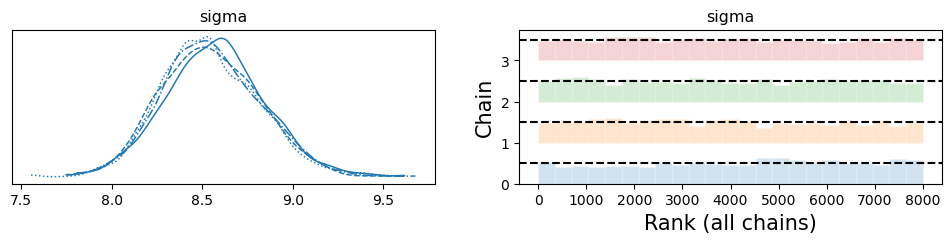

In [8]:
az.plot_trace(idata_bart_model, var_names=["sigma"], kind="rank_bars")

array([<Axes: xlabel='ESS'>, <Axes: xlabel='R-hat'>], dtype=object)

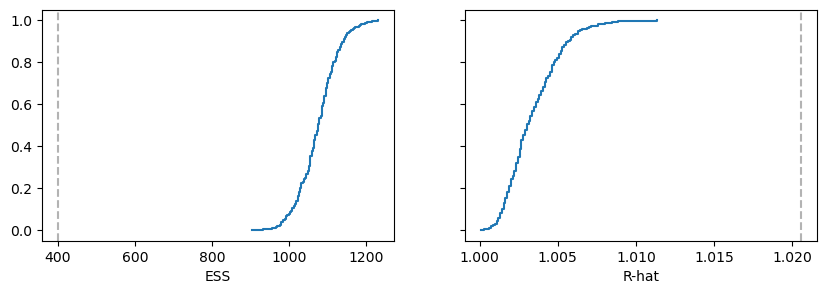

In [9]:
pmb.plot_convergence(idata_bart_model, var_name="mu")

In [10]:
pm.summary(idata_bart_model)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,8.553,0.270,8.071,9.072,0.005,0.004,2915.0,5483.0,1.0
mu[0],24.504,1.720,21.174,27.671,0.052,0.037,1082.0,1718.0,1.0
mu[1],22.117,1.521,19.088,24.800,0.045,0.032,1129.0,2073.0,1.0
mu[2],22.001,1.541,19.278,25.046,0.046,0.033,1122.0,2085.0,1.0
mu[3],22.564,1.602,19.531,25.546,0.048,0.034,1103.0,1949.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[498],25.978,1.348,23.473,28.525,0.041,0.029,1083.0,1979.0,1.0
mu[499],24.923,1.430,22.258,27.621,0.045,0.032,1013.0,1821.0,1.0
mu[500],26.745,1.482,24.046,29.576,0.046,0.033,1027.0,1850.0,1.0
mu[501],27.169,1.431,24.524,29.934,0.044,0.031,1064.0,1994.0,1.0


# 3. Inference

## 3.1 Training Scores

In [11]:
with bart_model:
    posterior_preds = pm.sample_posterior_predictive(idata_bart_model, model=bart_model, return_inferencedata=False)

Sampling: [y]


In [12]:
y_pred_mean = posterior_preds['y'].mean(axis=0).mean(axis=0)
y_pred_median = np.median(posterior_preds['y'], axis=0).mean(axis=0)

In [13]:
print('RMSE TRAIN MEAN : {}'.format(np.sqrt(mean_squared_error(Y_train, y_pred_mean))))
print('MAE TRAIN MEAN : {}'.format(mean_absolute_error(Y_train, y_pred_mean)))
print('RMSE TRAIN MEDIAN : {}'.format(np.sqrt(mean_squared_error(Y_train, y_pred_median))))
print('MAE TRAIN MEDIAN : {}'.format(mean_absolute_error(Y_train, y_pred_median)))

RMSE TRAIN MEAN : 8.372817070022817
MAE TRAIN MEAN : 6.551949785704402
RMSE TRAIN MEDIAN : 8.372679308616062
MAE TRAIN MEDIAN : 6.553184459499786


## 3.2 Test Score

In [14]:
with bart_model:
    X.set_value(X_test)
    posterior_predictive_test = pm.sample_posterior_predictive(idata_bart_model, model=bart_model, return_inferencedata=False)

Sampling: [mu, y]


In [15]:
y_pred_mean_test = posterior_predictive_test['y'].mean(axis=0).mean(axis=0)
y_pred_median_test = np.median(posterior_predictive_test['y'], axis=0).mean(axis=0)

In [17]:
print('RMSE TEST MEAN : {}'.format(np.sqrt(mean_squared_error(Y_test, y_pred_mean_test))))
print('MAE TEST MEAN : {}'.format(mean_absolute_error(Y_test, y_pred_mean_test)))
print('RMSE TEST MEDIAN : {}'.format(np.sqrt(mean_squared_error(Y_test, y_pred_median_test))))
print('MAE TEST MEDIAN : {}'.format(mean_absolute_error(Y_test, y_pred_median_test)))

RMSE TEST MEAN : 9.823810390768282
MAE TEST MEAN : 7.757772779586433
RMSE TEST MEDIAN : 9.82293816139543
MAE TEST MEDIAN : 7.757608410109792


# 4. Predicting on Single Out of Sample/Betting Line

In [18]:
# Grabbing a single datapoint to make predictions and create a point total player player prop line
sample_input = np.array([X_test.iloc[0, :].values])

In [19]:
sample_input

array([[ 23.        ,   9.        ,  11.        ,   5.        ,
          0.18181818,   0.4       ,   1.        ,  38.85327101,
          8.8       ,   0.3686    ,  15.8       ,   0.447     ,
         15.8       ,   0.6       ,  19.69579371, 122.        ,
         30.5       ,   0.45901639,  14.        ,   0.14285714,
          5.5       ,  15.        ,  96.56862745, 102.5       ,
         24.5       ,  38.        ,   7.625     ,   3.5       ,
          5.5       ,  24.84848485]])

In [20]:
with bart_model:
    X.set_value(sample_input)
    posterior_predictive_point = pm.sample_posterior_predictive(idata_bart_model, model=bart_model, return_inferencedata=False)

Sampling: [mu, y]


In [21]:
posterior_preds_point = posterior_predictive_point['y'].mean(axis=0)

In [22]:
np.median(posterior_predictive_point['y'].mean(axis=0))

26.742691094754335

In [23]:
point_value = 26.5
points_prob = len(posterior_preds_point[posterior_preds_point > point_value]) / len(posterior_preds_point)
print('Probability of Steph scoring more than {} : {}'.format(point_value, points_prob))
print('Player Prop Betting Line : {}'.format(odds_calculator(points_prob)))

Probability of Steph scoring more than 26.5 : 0.5195
Player Prop Betting Line : -108.11654526534858


In [24]:
# How much did Steph actually score that night?
Y_test.iloc[-1]

26

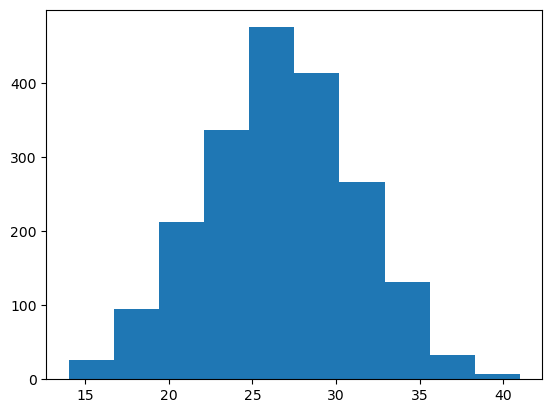

In [25]:
plt.hist(posterior_predictive_point['y'].mean(axis=0))
plt.show()